<a href="https://colab.research.google.com/github/seyed-mohammadreza-mousavi/ml-playground-starter/blob/main/LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Linear Discriminant Analysis (LDA): Theory, Implementation, and Visualization

This notebook provides a **complete** overview of Linear Discriminant Analysis (LDA), including the math, derivation, implementation from scratch, and visualizations on toy and real datasets.

---



## 1. Motivation and Probabilistic Background

We start from **Bayes’ theorem** for a class label $y \in \{1,\ldots,C\}$ and a feature vector $\mathbf{x} = (x_1,\ldots,x_d)$:
$$
P(y \mid \mathbf{x}) = \frac{P(\mathbf{x}\mid y)\,P(y)}{P(\mathbf{x})}
\;\propto\;
P(\mathbf{x}\mid y)\,P(y).
$$

In **Linear Discriminant Analysis (LDA)** we assume class-conditional **Gaussian** distributions with a **shared covariance** matrix:
$$
\mathbf{x}\mid y=c \sim \mathcal{N}(\boldsymbol{\mu}_c, \boldsymbol{\Sigma}), \qquad \text{for all } c \in \{1,\ldots,C\}.
$$

Under this assumption, the **log-posterior** is (up to an additive constant independent of $c$) an **affine function** of $\mathbf{x}$:
$$
\log P(y=c\mid \mathbf{x})
= \mathbf{x}^\top \boldsymbol{\Sigma}^{-1}\boldsymbol{\mu}_c
-\tfrac{1}{2}\boldsymbol{\mu}_c^\top \boldsymbol{\Sigma}^{-1}\boldsymbol{\mu}_c
+ \log \pi_c,
$$
where $\pi_c = P(y=c)$ is the class prior.
Hence the **decision rule** is linear in $\mathbf{x}$.



## 2. Fisher's Linear Discriminant (Projection View)

LDA can also be derived as a **supervised dimensionality reduction** technique. We seek a projection matrix $\mathbf{W}\in\mathbb{R}^{d\times m}$, $m\le C-1$, that maximizes class separability in the projected space.

Define the **class means** and **global mean**:
$$
\boldsymbol{\mu}_c = \frac{1}{N_c}\sum_{i: y_i=c}\mathbf{x}_i, \qquad
\boldsymbol{\mu} = \frac{1}{N}\sum_{i=1}^N \mathbf{x}_i.
$$

The **within-class scatter** and **between-class scatter** are
$$
\mathbf{S}_W = \sum_{c=1}^C \sum_{i: y_i=c} (\mathbf{x}_i-\boldsymbol{\mu}_c)(\mathbf{x}_i-\boldsymbol{\mu}_c)^\top,
\qquad
\mathbf{S}_B = \sum_{c=1}^C N_c(\boldsymbol{\mu}_c-\boldsymbol{\mu})(\boldsymbol{\mu}_c-\boldsymbol{\mu})^\top.
$$

Fisher's criterion maximizes
$$
J(\mathbf{W}) = \frac{\det\left(\mathbf{W}^\top \mathbf{S}_B \mathbf{W}\right)}{\det\left(\mathbf{W}^\top \mathbf{S}_W \mathbf{W}\right)}.
$$

The solution consists of the top $m$ **generalized eigenvectors** $\{\mathbf{w}_k\}$ of
$$
\mathbf{S}_B \mathbf{w} = \lambda \mathbf{S}_W \mathbf{w},
$$
i.e., the eigenvectors of $\mathbf{S}_W^{-1}\mathbf{S}_B$ (with appropriate regularization if $\mathbf{S}_W$ is singular).



## 3. Relation Between the Two Views

Under the Gaussian **shared-covariance** assumption,
$$
\boldsymbol{\Sigma} = \frac{1}{N-C}\sum_{c=1}^C \sum_{i: y_i=c} (\mathbf{x}_i-\boldsymbol{\mu}_c)(\mathbf{x}_i-\boldsymbol{\mu}_c)^\top,
$$
LDA's **discriminant function**
$$
g_c(\mathbf{x}) \equiv \mathbf{x}^\top \boldsymbol{\Sigma}^{-1}\boldsymbol{\mu}_c
-\tfrac{1}{2}\boldsymbol{\mu}_c^\top \boldsymbol{\Sigma}^{-1}\boldsymbol{\mu}_c
+ \log \pi_c
$$
leads to **linear decision boundaries**. The **projection view** (Fisher LDA) and the **generative view** (Gaussian LDA) are consistent and often implemented together: use the Fisher directions for dimensionality reduction and the generative rule for classification.



## 4. Assumptions, Regularization, and Practical Notes

- **Shared covariance**: all classes share the same $\boldsymbol{\Sigma}$. When this is violated, **Quadratic Discriminant Analysis (QDA)** may be more appropriate.
- **Regularization**: when $d$ is large vs $N$, $\mathbf{S}_W$ or $\boldsymbol{\Sigma}$ can be ill-conditioned. One can use a ridge term: $\boldsymbol{\Sigma}_\lambda = \boldsymbol{\Sigma} + \lambda \mathbf{I}$ with small $\lambda>0$.
- **Max number of LDA components**: the subspace dimension is at most $C-1$.
- **Standardization**: it is common to standardize features before fitting.


In [1]:

# 5. Imports
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, Tuple
from sklearn.datasets import load_iris, make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as SklearnLDA
np.random.seed(42)



## 6. From-Scratch Implementation

We implement two pieces:

1. **Fisher directions** via the generalized eigenproblem of $\mathbf{S}_W^{-1}\mathbf{S}_B$ (for supervised dimensionality reduction).
2. **Generative LDA classifier** using the shared-covariance Gaussian model with discriminant $g_c(\mathbf{x})$.


In [2]:

@dataclass
class LDAFromScratch:
    n_components: Optional[int] = None
    reg: float = 1e-6  # ridge for numerical stability

    # Learned parameters
    classes_: np.ndarray = None
    priors_: np.ndarray = None
    means_: np.ndarray = None      # shape (C, d)
    Sigma_: np.ndarray = None      # shared covariance (d, d)
    W_: Optional[np.ndarray] = None  # projection matrix (d, m)

    def fit(self, X: np.ndarray, y: np.ndarray):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y)
        self.classes_, y_idx = np.unique(y, return_inverse=True)
        C = len(self.classes_)
        N, d = X.shape

        # Means per class and priors
        self.means_ = np.vstack([X[y_idx == c].mean(axis=0) for c in range(C)])
        counts = np.bincount(y_idx)
        self.priors_ = counts / counts.sum()

        # Within-class scatter SW and between-class scatter SB
        mu = X.mean(axis=0)
        SW = np.zeros((d, d))
        SB = np.zeros((d, d))
        for c in range(C):
            Xc = X[y_idx == c]
            centered = Xc - self.means_[c]
            SW += centered.T @ centered
            mean_diff = (self.means_[c] - mu).reshape(-1, 1)
            SB += counts[c] * (mean_diff @ mean_diff.T)

        # Shared covariance estimate (pooled)
        self.Sigma_ = SW / (N - C)
        # Regularization for numerical stability
        self.Sigma_ = self.Sigma_ + self.reg * np.eye(d)

        # Fisher projection directions (optional)
        m = self.n_components if self.n_components is not None else min(d, C - 1)
        # Solve generalized eigenproblem via eig of inv(SW) SB (with regularization)
        # For stability, solve linear system rather than explicit inverse
        from numpy.linalg import solve, eig
        A = solve(self.Sigma_, SB)  # equivalent to inv(SW) @ SB under Gaussian-LDA
        eigvals, eigvecs = eig(A)
        # Sort by descending eigenvalues (real part)
        order = np.argsort(-eigvals.real)
        W = eigvecs[:, order[:m]].real
        # Orthonormalize columns via QR for numerical stability
        Q, _ = np.linalg.qr(W)
        self.W_ = Q[:, :m]
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        if self.W_ is None:
            raise ValueError("Model is not fitted with projection. Fit first.")
        return np.asarray(X, dtype=float) @ self.W_

    def decision_function(self, X: np.ndarray) -> np.ndarray:
        X = np.asarray(X, dtype=float)
        # Precompute Sigma^{-1}
        Sigma_inv = np.linalg.inv(self.Sigma_)
        C = len(self.classes_)
        scores = np.zeros((X.shape[0], C))
        for c in range(C):
            mu_c = self.means_[c]
            term1 = X @ (Sigma_inv @ mu_c)
            term2 = -0.5 * (mu_c.T @ Sigma_inv @ mu_c)
            term3 = np.log(self.priors_[c] + 1e-12)
            scores[:, c] = term1 + term2 + term3
        return scores

    def predict(self, X: np.ndarray) -> np.ndarray:
        scores = self.decision_function(X)
        idx = scores.argmax(axis=1)
        return self.classes_[idx]


In [3]:

def plot_decision_regions_2d(model, X, y, title="Decision regions", h=0.02, ax=None):
    import numpy as np
    import matplotlib.pyplot as plt
    if ax is None:
        fig, ax = plt.subplots()
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.25)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
    ax.set_title(title)
    return ax



## 7. Example 1 — Iris Dataset (3 classes)

We fit our from-scratch LDA and compare with `scikit-learn`. We also visualize the data projected to $C-1=2$ dimensions via Fisher LDA.


From-scratch LDA accuracy (test): 0.9777777777777777
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0.97        15
           2       1.00      0.93      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45

Confusion matrix:
 [[15  0  0]
 [ 0 15  0]
 [ 0  1 14]]


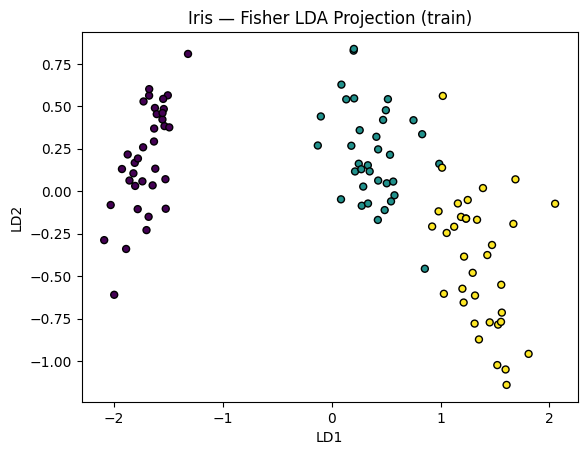

In [4]:

# Load and split Iris
iris = load_iris()
X = iris.data
y = iris.target
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# From-scratch LDA (2 components because C-1=2 for Iris)
lda_fs = LDAFromScratch(n_components=2, reg=1e-4).fit(X_train, y_train)
Z_train = lda_fs.transform(X_train)
Z_test = lda_fs.transform(X_test)

# Train a simple linear classifier in the projected space by reusing LDA's own discriminant
# (prediction uses the generative discriminant already)
y_pred_fs = lda_fs.predict(X_test)
acc_fs = accuracy_score(y_test, y_pred_fs)

print("From-scratch LDA accuracy (test):", acc_fs)
print(classification_report(y_test, y_pred_fs))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_fs))

# Plot the 2D Fisher projection (no decision regions yet, since original LDA predicts in original space)
plt.figure()
plt.scatter(Z_train[:,0], Z_train[:,1], c=y_train, s=25, edgecolor='k')
plt.title("Iris — Fisher LDA Projection (train)")
plt.xlabel("LD1"); plt.ylabel("LD2")
plt.show()


sklearn LDA accuracy (test): 0.9777777777777777
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0.97        15
           2       1.00      0.93      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45

Confusion matrix (sklearn):
 [[15  0  0]
 [ 0 15  0]
 [ 0  1 14]]


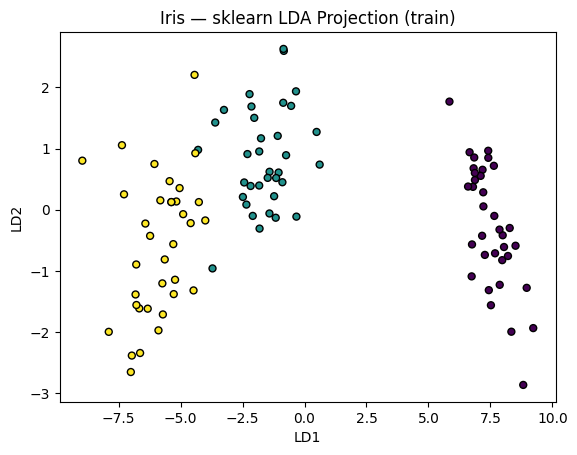

In [5]:

# scikit-learn LDA for comparison
sk_lda = SklearnLDA(n_components=2)
sk_lda.fit(X_train, y_train)
y_pred_sk = sk_lda.predict(X_test)
acc_sk = accuracy_score(y_test, y_pred_sk)
print("sklearn LDA accuracy (test):", acc_sk)
print(classification_report(y_test, y_pred_sk))
print("Confusion matrix (sklearn):\n", confusion_matrix(y_test, y_pred_sk))

# Project with sklearn LDA
Z_train_sk = sk_lda.transform(X_train)
plt.figure()
plt.scatter(Z_train_sk[:,0], Z_train_sk[:,1], c=y_train, s=25, edgecolor='k')
plt.title("Iris — sklearn LDA Projection (train)")
plt.xlabel("LD1"); plt.ylabel("LD2")
plt.show()



## 8. Example 2 — Toy Blobs (2D) with Decision Regions

We generate a 3-class 2D dataset and visualize the **linear decision boundaries** produced by LDA.


Blobs — from-scratch LDA accuracy: 0.9888888888888889


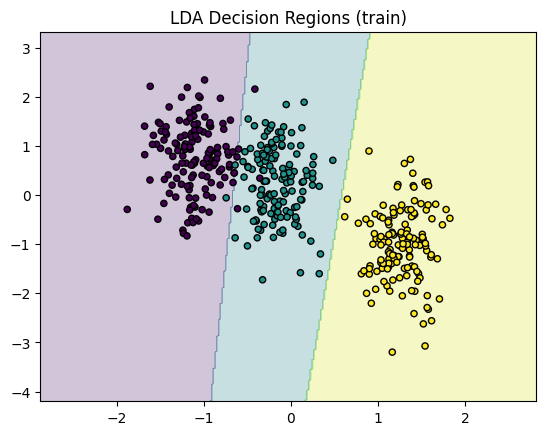

In [6]:

Xb, yb = make_blobs(n_samples=600, centers=3, cluster_std=2.0, random_state=7)
Xb = StandardScaler().fit_transform(Xb)
Xb_tr, Xb_te, yb_tr, yb_te = train_test_split(Xb, yb, test_size=0.3, stratify=yb, random_state=7)

lda_blobs = LDAFromScratch(n_components=2, reg=1e-4).fit(Xb_tr, yb_tr)
yp = lda_blobs.predict(Xb_te)
print("Blobs — from-scratch LDA accuracy:", accuracy_score(yb_te, yp))

# Since the data is already 2D, we can plot the decision regions directly
fig, ax = plt.subplots()
plot_decision_regions_2d(lda_blobs, Xb_tr, yb_tr, title="LDA Decision Regions (train)", ax=ax)
plt.show()



## 9. Explicit Decision Rule

Given estimates of $\boldsymbol{\mu}_c$, $\boldsymbol{\Sigma}$, and $\pi_c$, the LDA discriminant is:
$$
g_c(\mathbf{x})
= \mathbf{x}^\top \boldsymbol{\Sigma}^{-1}\boldsymbol{\mu}_c
-\tfrac{1}{2}\boldsymbol{\mu}_c^\top \boldsymbol{\Sigma}^{-1}\boldsymbol{\mu}_c
+ \log \pi_c.
$$
We predict $\hat{y}=\arg\max_c g_c(\mathbf{x})$.



## 10. Algorithmic Summary (Pseudocode)

**Fit** on data matrix $X\in\mathbb{R}^{N\times d}$ and labels $y$:
1. Compute class means $\boldsymbol{\mu}_c$ and priors $\pi_c$.
2. Compute pooled covariance (within-class scatter) $\boldsymbol{\Sigma}$ and regularize $\boldsymbol{\Sigma}_\lambda=\boldsymbol{\Sigma}+\lambda\mathbf{I}$.
3. (Optional) Solve generalized eigenproblem for Fisher projection $\mathbf{S}_B\mathbf{w}=\lambda\mathbf{S}_W\mathbf{w}$ to obtain up to $C-1$ directions.
4. Store $\{\boldsymbol{\mu}_c\}$, $\boldsymbol{\Sigma}_\lambda$, $\{\pi_c\}$ (and projection $\mathbf{W}$ if needed).

**Predict** on a new $\mathbf{x}$:
1. Compute $g_c(\mathbf{x})$ for each class using the formula above.
2. Return the class with the largest score.



## 11. When LDA Works Well (and When It Doesn't)

LDA shines when:
- Classes are approximately Gaussian with similar covariances.
- Sample size is moderate and you need a low-dimensional **supervised** projection (up to $C-1$).

Consider alternatives when:
- Covariances differ substantially across classes (use QDA).
- Distributions are multi-modal or not well-approximated by Gaussians (try discriminative models or mixtures).
- $d \gg N$: use stronger regularization or prior dimensionality reduction.



## 12. Reproducibility

All random seeds are fixed where relevant for reproducible splits. You can re-run the notebook end-to-end to reproduce the figures and metrics.
